In [1]:
print("Loading Libraries...")
import os, sys
import csv
import platform
import numpy as np
import pandas as pd
import dask.dataframe as dd
import scipy
import sklearn
import matplotlib.pyplot as plt
import flask
import math
import scipy.interpolate as scin
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from sklearn import neighbors, datasets
print("Loaded Libraries...")

Loading Libraries...
Loaded Libraries...


In [2]:
print("Starting code...")

Starting code...


In [3]:
print("Loading directories..")
path_data = 'D:/01_Dokumenty/01_PUT/01_DOKTORAT/13_PLGRID/noise-data/int-01'
path_post = 'D:/01_Dokumenty/01_PUT/01_DOKTORAT/13_PLGRID/noise-data/int-01/post'
path_acu = 'D:/01_Dokumenty/01_PUT/01_DOKTORAT/13_PLGRID/noise-data/int-01/post/acu'
path_plots = 'D:/01_Dokumenty/01_PUT/01_DOKTORAT/13_PLGRID/noise-data/int-01/post/plots' #ścieżka do katalogu z interesującymi nas plikami
print("Loaded directories...")

Loading directories..
Loaded directories...


In [4]:
print("Loading batch data...")
os.chdir(path_data)
batch_data = dd.read_csv('int-01-*.dat', delimiter=r"\s+", decimal='.')
print("Batch data done...")

Loading batch data...
Batch data done...


In [5]:
print("Calculating batch averages...")
averages = pd.DataFrame(batch_data.groupby('nodenumber').mean().compute())
print("Batch averages done...")

Calculating batch averages...
Batch averages done...


In [6]:
print("Generating node coordinates...")
avg_static_p = pd.DataFrame({'pressure': averages['pressure']})
node_coords = pd.DataFrame({
    'x-coordinate': averages['x-coordinate'],
    'y-coordinate': averages['y-coordinate'],
    'z-coordinate': averages['z-coordinate']
})
print("Node coordinates done...")

Generating node coordinates...
Node coordinates done...


In [7]:
del(batch_data)
print("Batch data deleted...")

Batch data deleted...


In [8]:
print("Listing files...")
filelist = os.listdir(path_data)

Listing files...


In [9]:
print("Starting noise analysis loop...")
for file in filelist:
    os.chdir(path_data)
    timestep = str(os.path.basename(str(file)))[7:-4]
    #time_static_p = pd.DataFrame(pd.read_csv(file, sep='/s+', header=0, usecols=["nodenumber", "pressure"], skiprows=0, decimal='.')).set_index('nodenumber')
    time_static_p = pd.DataFrame(pd.read_csv(file, delimiter=r"\s+", header=0, usecols=["nodenumber", "pressure"], skiprows=0, decimal='.')).set_index('nodenumber')
    acoustic_p = time_static_p.subtract(avg_static_p, fill_value=None)
    db = acoustic_p.apply(lambda x: 20 * np.log10(np.abs(x)/0.00002), axis=1)
    acoustic_data = pd.concat([node_coords, acoustic_p, db], axis=1)
    acoustic_data.columns = ['x-coordinate', 'y-coordinate', 'z-coordinate', 'sound-pressure', 'db-level']
    os.chdir(path_acu)
    acoustic_data.to_csv(str('int-01_acu_' + str(timestep) + '.dat'), sep=',')
    print(str('int-01_acu_' + str(timestep) + '.dat done...'))
print("Exiting noise analysis loop...")

Starting noise analysis loop...
int-01_acu_0001.dat done...
int-01_acu_0002.dat done...
int-01_acu_0003.dat done...
int-01_acu_0004.dat done...
int-01_acu_0005.dat done...
int-01_acu_0006.dat done...
int-01_acu_0007.dat done...
int-01_acu_0008.dat done...
int-01_acu_0009.dat done...
int-01_acu_0010.dat done...
int-01_acu_0011.dat done...
int-01_acu_0012.dat done...
int-01_acu_0013.dat done...
int-01_acu_0014.dat done...
int-01_acu_0015.dat done...
int-01_acu_0016.dat done...
int-01_acu_0017.dat done...
int-01_acu_0018.dat done...
int-01_acu_0019.dat done...
int-01_acu_0020.dat done...
int-01_acu_0021.dat done...
int-01_acu_0022.dat done...
int-01_acu_0023.dat done...
int-01_acu_0024.dat done...
int-01_acu_0025.dat done...
int-01_acu_0026.dat done...
int-01_acu_0027.dat done...
int-01_acu_0028.dat done...
int-01_acu_0029.dat done...
int-01_acu_0030.dat done...
int-01_acu_0031.dat done...
int-01_acu_0032.dat done...
int-01_acu_0033.dat done...
int-01_acu_0034.dat done...
int-01_acu_0035.

int-01_acu_0293.dat done...
int-01_acu_0294.dat done...
int-01_acu_0295.dat done...
int-01_acu_0296.dat done...
int-01_acu_0297.dat done...
int-01_acu_0298.dat done...
int-01_acu_0299.dat done...
int-01_acu_0300.dat done...
int-01_acu_0301.dat done...
int-01_acu_0302.dat done...
int-01_acu_0303.dat done...
int-01_acu_0304.dat done...
int-01_acu_0305.dat done...
int-01_acu_0306.dat done...
int-01_acu_0307.dat done...
int-01_acu_0308.dat done...
int-01_acu_0309.dat done...
int-01_acu_0310.dat done...
int-01_acu_0311.dat done...
int-01_acu_0312.dat done...
int-01_acu_0313.dat done...
int-01_acu_0314.dat done...
int-01_acu_0315.dat done...
int-01_acu_0316.dat done...
int-01_acu_0317.dat done...
int-01_acu_0318.dat done...
int-01_acu_0319.dat done...
int-01_acu_0320.dat done...
int-01_acu_0321.dat done...
int-01_acu_0322.dat done...
int-01_acu_0323.dat done...
int-01_acu_0324.dat done...
int-01_acu_0325.dat done...
int-01_acu_0326.dat done...
int-01_acu_0327.dat done...
int-01_acu_0328.dat 

int-01_acu_0586.dat done...
int-01_acu_0587.dat done...
int-01_acu_0588.dat done...
int-01_acu_0589.dat done...
int-01_acu_0590.dat done...
int-01_acu_0591.dat done...
int-01_acu_0592.dat done...
int-01_acu_0593.dat done...
int-01_acu_0594.dat done...
int-01_acu_0595.dat done...
int-01_acu_0596.dat done...
int-01_acu_0597.dat done...
int-01_acu_0598.dat done...
int-01_acu_0599.dat done...
int-01_acu_0600.dat done...
int-01_acu_0601.dat done...
int-01_acu_0602.dat done...
int-01_acu_0603.dat done...
int-01_acu_0604.dat done...
int-01_acu_0605.dat done...
int-01_acu_0606.dat done...
int-01_acu_0607.dat done...
int-01_acu_0608.dat done...
int-01_acu_0609.dat done...
int-01_acu_0610.dat done...
int-01_acu_0611.dat done...
int-01_acu_0612.dat done...
int-01_acu_0613.dat done...
int-01_acu_0614.dat done...
int-01_acu_0615.dat done...
int-01_acu_0616.dat done...
int-01_acu_0617.dat done...
int-01_acu_0618.dat done...
int-01_acu_0619.dat done...
int-01_acu_0620.dat done...
int-01_acu_0621.dat 

KeyboardInterrupt: 

In [16]:
print("Loading batch acoustic data...")
os.chdir(path_acu)
batch_data = dd.read_csv('int-01*.dat', sep=',', decimal='.')
print("Batch data done...")

Loading batch acoustic data...
Batch data done...


In [17]:
print("Calculating batch minimums...")
minima = pd.DataFrame(batch_data.groupby('nodenumber').min().compute())
print("Batch minimums done...")

Calculating batch minimums...
Batch minimums done...


In [26]:
min_spl=np.amin(minima['sound-pressure'])
min_dbl=np.amin(minima['db-level'])
print(min_spl)
print(min_dbl)

-14360.1998444
17.629099526


In [30]:
print("Calculating batch maximums...")
maxima = pd.DataFrame(batch_data.groupby('nodenumber').max().compute())
print("Batch maximums done...")

Calculating batch maximums...
Batch maximums done...


In [28]:
max_spl=np.amax(maxima['sound-pressure'])
max_dbl=np.amax(maxima['db-level'])
print(max_spl)
print(max_dbl)

11846.6950986
177.122609763


In [31]:
print("Calculating batch std dev...")
std_devs = pd.DataFrame(batch_data.groupby('nodenumber').max().compute())
print("Batch std dev done...")

Calculating batch std dev...
Batch std dev done...


In [43]:
print("Plot RMS values")
x = std_devs['x-coordinate']
y = std_devs['y-coordinate']
z = std_devs['z-coordinate']
spl = std_devs['sound-pressure']
dbl = std_devs['db-level']
min_splrms=np.amin(std_devs['sound-pressure'])
min_dblrms=np.amin(std_devs['db-level'])
max_splrms=np.amax(std_devs['sound-pressure'])
max_dblrms=np.amax(std_devs['db-level'])

splv = np.linspace(min_splrms, max_splrms, 100, endpoint=False)
dbv = np.linspace(min_dblrms, max_dblrms, num=100, endpoint=False)

Plot RMS values


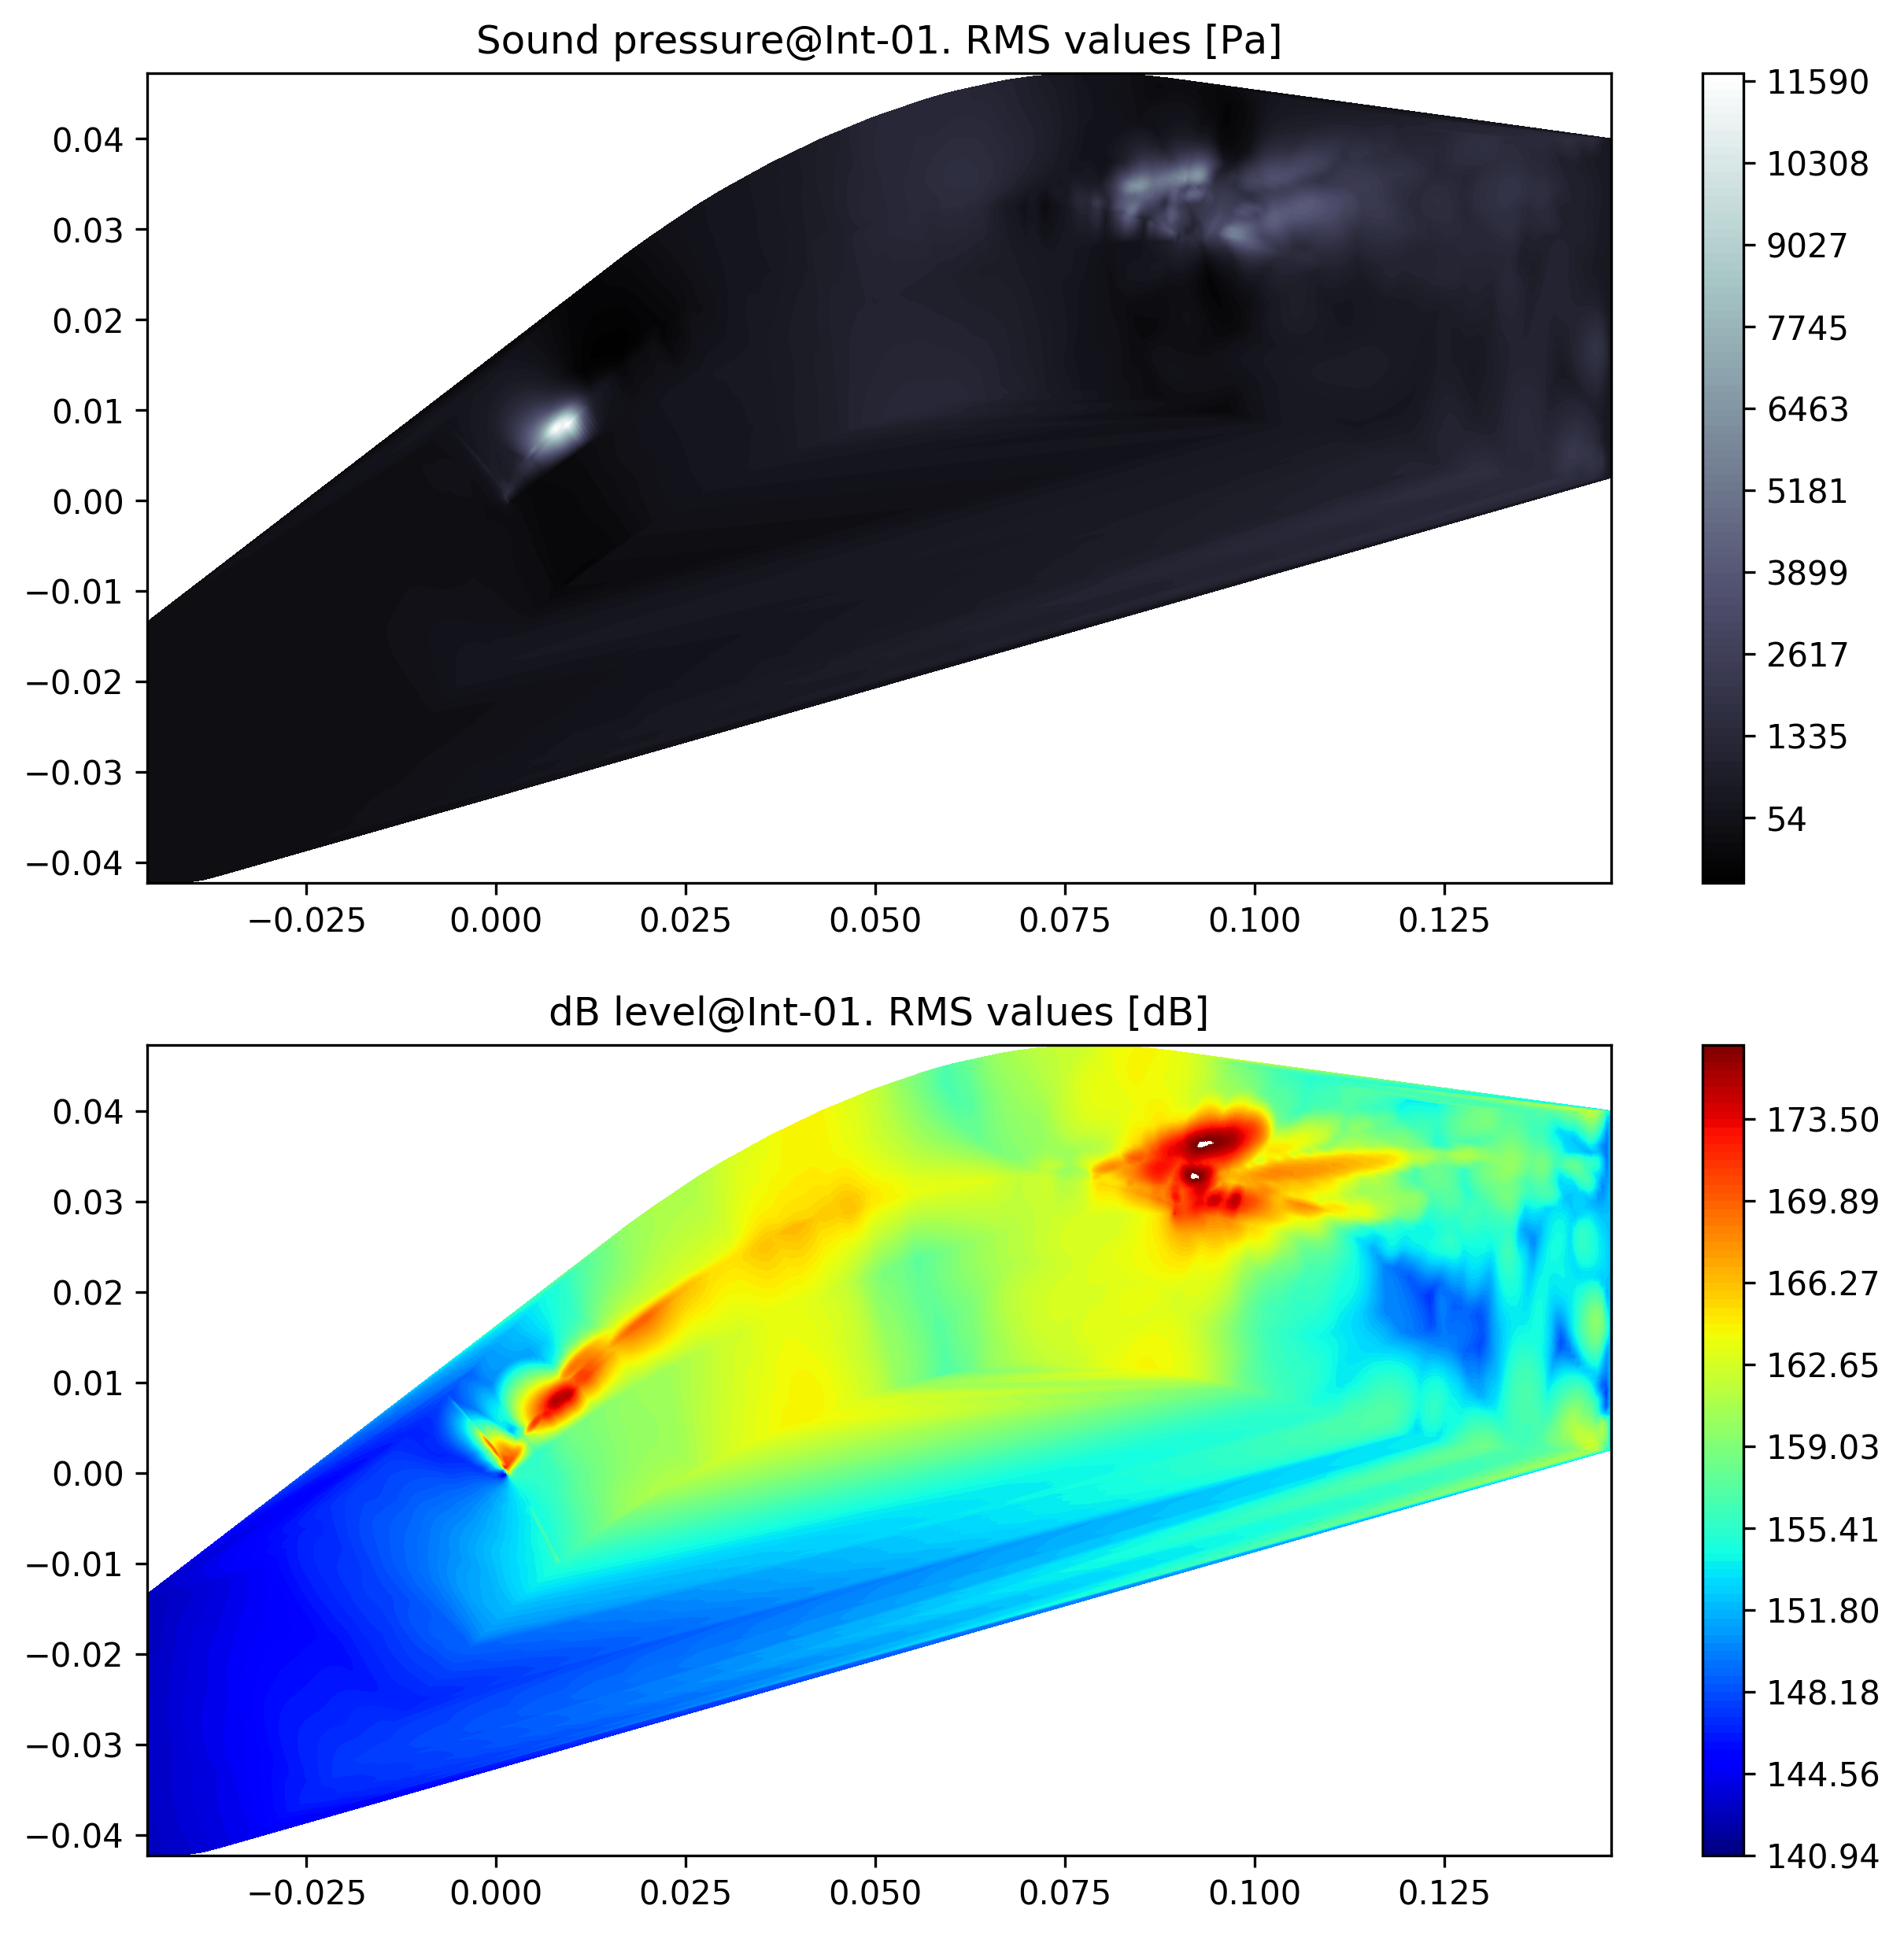

In [46]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(10, 10), dpi=300)
spl_plot = ax0.tricontourf(z, x, spl, splv, cmap=plt.cm.bone)
fig.colorbar(spl_plot, ax=ax0)
ax0.set_title("Sound pressure@Int-01. RMS values [Pa]")
dbl_plot = ax1.tricontourf(z, x, dbl, dbv, cmap=plt.cm.jet)
fig.colorbar(dbl_plot, ax=ax1)
ax1.set_title("dB level@Int-01. RMS values [dB]")
plt.show()

In [40]:
print("Starting plotting loop...")
splv = np.linspace(min_spl, max_spl, 100, endpoint=False)
dbv = np.linspace(min_dbl, max_dbl, num=100, endpoint=False)
os.chdir(path_acu)
filelist = os.listdir(path_acu)
for file in filelist:
    timestep = str(os.path.basename(str(file)))[11:-4]
    os.chdir(path_acu)
    acu = pd.read_csv(file, sep=',', decimal='.', header=0)
    x = acu['x-coordinate']
    y = acu['y-coordinate']
    z = acu['z-coordinate']
    spl = acu['sound-pressure']
    dbl = acu['db-level']
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(10, 10), dpi=300)
    spl_plot = ax0.tricontourf(z, x, spl, splv, cmap=plt.cm.bone)
    fig.colorbar(spl_plot, ax=ax0)
    ax0.set_title(str('Sound pressure. Int-01. Time: ' + str(timestep)))
    dbl_plot = ax1.tricontourf(z, x, dbl, dbv, cmap=plt.cm.jet)
    fig.colorbar(dbl_plot, ax=ax1)
    ax1.set_title(str('dB level. Int-01. Time: ' + str(timestep)))
    os.chdir(path_plots)
    plt.savefig(str('int-01_acu_t_' + str(timestep) + '.png'))
    plt.close()
    print(str('int-01_acu_t_' + str(timestep) + '.png done...'))
print("Exiting plotting loop...")

Starting plotting loop...
int-01_acu_t_0001.png done...
int-01_acu_t_0002.png done...
int-01_acu_t_0003.png done...
int-01_acu_t_0004.png done...
int-01_acu_t_0005.png done...
int-01_acu_t_0006.png done...
int-01_acu_t_0007.png done...
int-01_acu_t_0008.png done...
int-01_acu_t_0009.png done...
int-01_acu_t_0010.png done...
int-01_acu_t_0011.png done...
int-01_acu_t_0012.png done...
int-01_acu_t_0013.png done...
int-01_acu_t_0014.png done...
int-01_acu_t_0015.png done...
int-01_acu_t_0016.png done...
int-01_acu_t_0017.png done...
int-01_acu_t_0018.png done...
int-01_acu_t_0019.png done...
int-01_acu_t_0020.png done...
int-01_acu_t_0021.png done...
int-01_acu_t_0022.png done...
int-01_acu_t_0023.png done...
int-01_acu_t_0024.png done...
int-01_acu_t_0025.png done...
int-01_acu_t_0026.png done...
int-01_acu_t_0027.png done...
int-01_acu_t_0028.png done...
int-01_acu_t_0029.png done...
int-01_acu_t_0030.png done...
int-01_acu_t_0031.png done...
int-01_acu_t_0032.png done...
int-01_acu_t_0

KeyboardInterrupt: 

squares = batch_data**2

squares

means = squares.groupby('nodenumber').mean().compute()

roots = np.sqrt(means)
roots